In [255]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import re
import os
import random
import datetime
import calendar
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from datetime import date
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import math
from sklearn.metrics import mean_squared_error
import csv
import dateutil
from pandas.tseries.offsets import DateOffset

Devo giustapporre le colonne per formare un'unica riga composta da 365 elementi.

Carico il dataset in formato .csv e il foglio .xlsx con i valori di anomalous settati correttamente.

Creo una colonna "Data" che servirà dopo.

Iterando le tuple del dataset scompongo le colonne giustappondendole e formando un'unica riga di dati.

In [269]:
df = pd.read_csv('timeSeries2015HotspotD.csv')
excel_path = 'anomalous_settati.xlsx'
settati = pd.read_excel(excel_path, sheet_name='Dati')

df["Data"] = 0
date = []

for row in df.itertuples(index=True, name='Pandas'):
  d = datetime.date(2015,row.Month,row.Day)
  date.append(d)

df["Data"] = date
df.set_index("Data")

df.to_csv("con_data.csv",index=False)

colonne = []
giorno = []
anomalous = []
j = 1
week = 1

df["Anomalous"] = settati["Anomalous"]

df.to_csv("out1.csv")

for riga in df.itertuples():
    i = 5  

    ## itero sulle colonne scomponendo e giustapponendo
    while i < 28 :
      giorno.append(pd.datetime(riga[28].year,riga[28].month,riga[28].day,i-4))
      colonne.append(riga[i])
      anomalous.append(riga[1])
      
      i += 1

dati_nuovi = pd.DataFrame(columns=["Data","Affluenza"])
dati_nuovi["Data"] = giorno
dati_nuovi["Affluenza"] = colonne

dati_nuovi.to_csv("vettorizzati.csv",index=False)

## per comodità aggiungo una colonna ridondante ai dati vettorizzati con l'indicazione di "Anomalous"
dati_nuovi["Anomalous"] = anomalous
dati_nuovi.to_csv("vettorizzati_con_anomalous.csv",index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


In <em> vettorizzati.csv </em> ho i dati giustapposti per colonna relativi a tutte le ore di tutti i giorni.

In [270]:
df = pd.read_csv("vettorizzati.csv",index_col = ["Data"])
df_plot = pd.read_csv("vettorizzati_con_anomalous.csv",index_col="Data")

Normalizzazione: 

In [271]:
train = df

scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

Creazione del modello e addestramento: 

In [ ]:
n_input = 24
n_features = 1

generator = TimeseriesGenerator(train, train, length=n_input, batch_size=32)
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(generator, epochs=100)

Creazione della predizione:

In [272]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

Inverto lo scaling: 

In [273]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=df[4000:4000+n_input].index, columns=['Prediction'])
df_test = pd.concat([df.iloc[4000:4200+n_input],df_predict], axis=1)

Plot dei risultati:

No handles with labels found to put in legend.


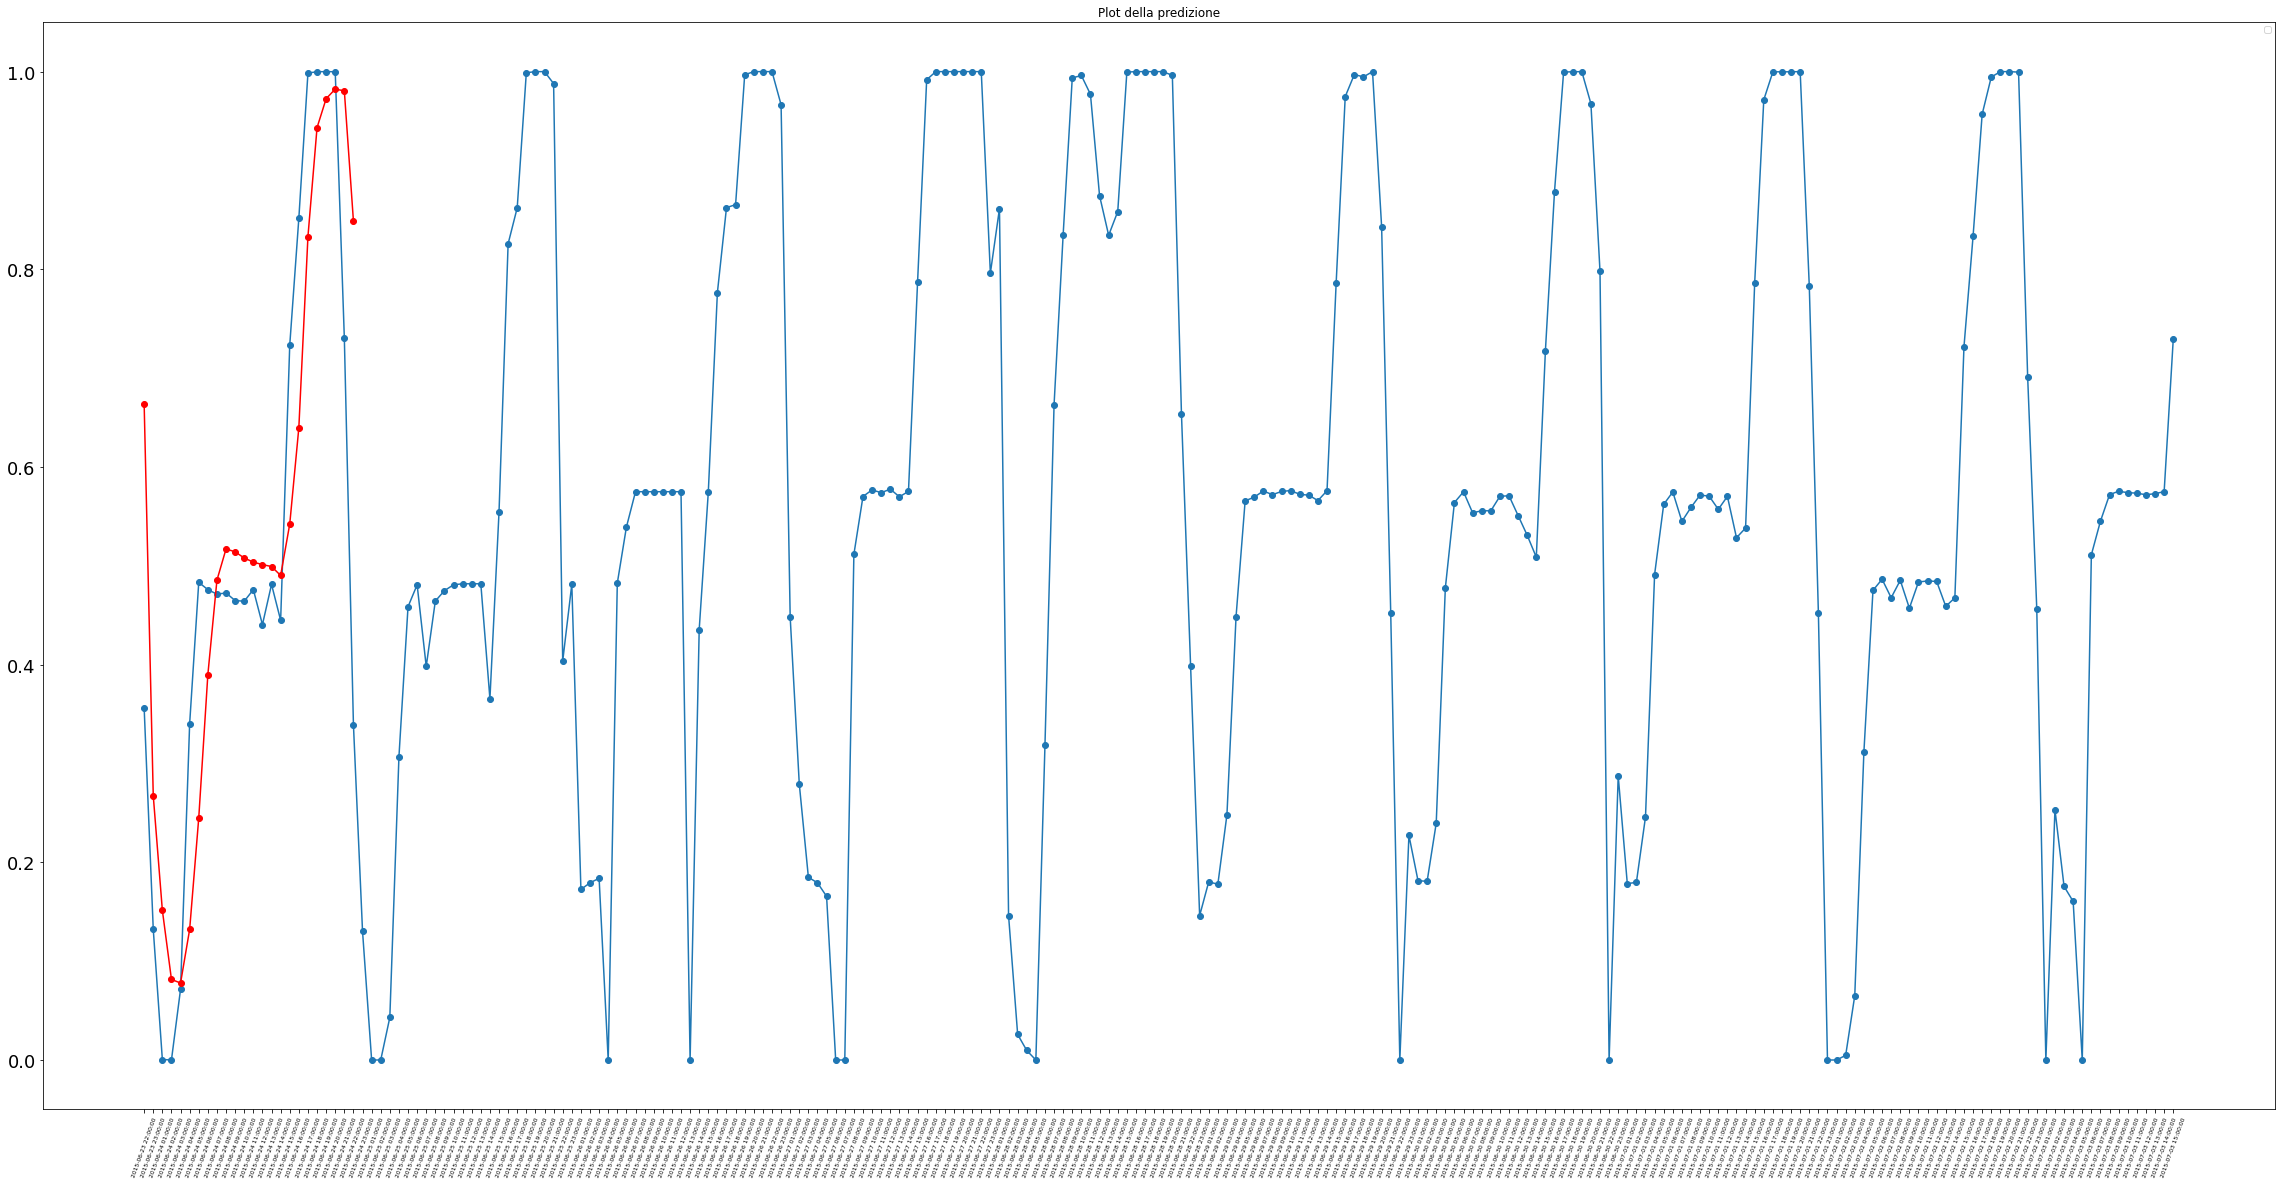

In [274]:
plt.figure(figsize=(40, 20))
plt.title("Plot della predizione")
plt.plot(df_test.index, df_test['Affluenza'],marker="o")
plt.plot(df_test.index, df_test['Prediction'], color='r', marker="o")
plt.legend(loc='best', fontsize='small')
plt.xticks(fontsize=6)
plt.yticks(fontsize=18)
plt.xticks(rotation=70)
plt.show()

Creazione dataframe formato da [["Settimana","Anomalous"]]

In [ ]:
import datetime 

serie = pd.read_csv("vettorizzati_con_anomalous.csv",index_col = ["Data"])

settimanale = []
anomalous_new = []
x = range(53)

## creo dataframe con anomalous non settati
for index in x :
  settimanale.append(index)
  anomalous_new.append(0)

dataframe_target = pd.DataFrame()
dataframe_target["Settimana"] = settimanale
dataframe_target["Anomalous"] = anomalous_new
dataframe_target.set_index("Settimana")

## itero sullo tuple del dataset
for riga in serie.itertuples() :
  day = datetime.datetime.strptime(riga[0],"%Y-%m-%d %H:%M:%S")
  skip = False

  ## Primo record di una settimana, Lunedì alle 01:00:00
  if day.weekday() == 0 and day.hour == 1:

    ## La settimana finisce tra 7 giorni a partire da oggi
    finish_date = datetime.datetime.strptime(riga[0],"%Y-%m-%d %H:%M:%S") + datetime.timedelta(days=7)
    
    ## Creo la finestra statica composta da 7 giorni

    base = day
    ## Prima dell'ultimo settimana registrata (non considero giorni non nel dataset)
    if base + datetime.timedelta(days=7) < pd.datetime(2015,12,31) :
      window = [base + datetime.timedelta(days=x) for x in range(7)]

      ## Scorro la finestra 
      for x in window :
        key = datetime.datetime.strptime(str(x),"%Y-%m-%d %H:%M:%S")

        ## Recupero il record relativo al giorno della settimana
        giorno_settimana = serie.loc[str(key)]

        ## Se è un giorno anomalo, tutta la settimana sarà segnalata come anomala
        if giorno_settimana["Anomalous"] == 1 :
          dataframe_target.loc[day.isocalendar()[1], "Anomalous"] = 1
          break


dataframe_target.to_csv("out2.csv",index=False)
new = pd.read_csv("out2.csv",index_col="Settimana")

print(new)

Plotto il dataset con giorni anomali a confronto con affluenza e settimane anomale.

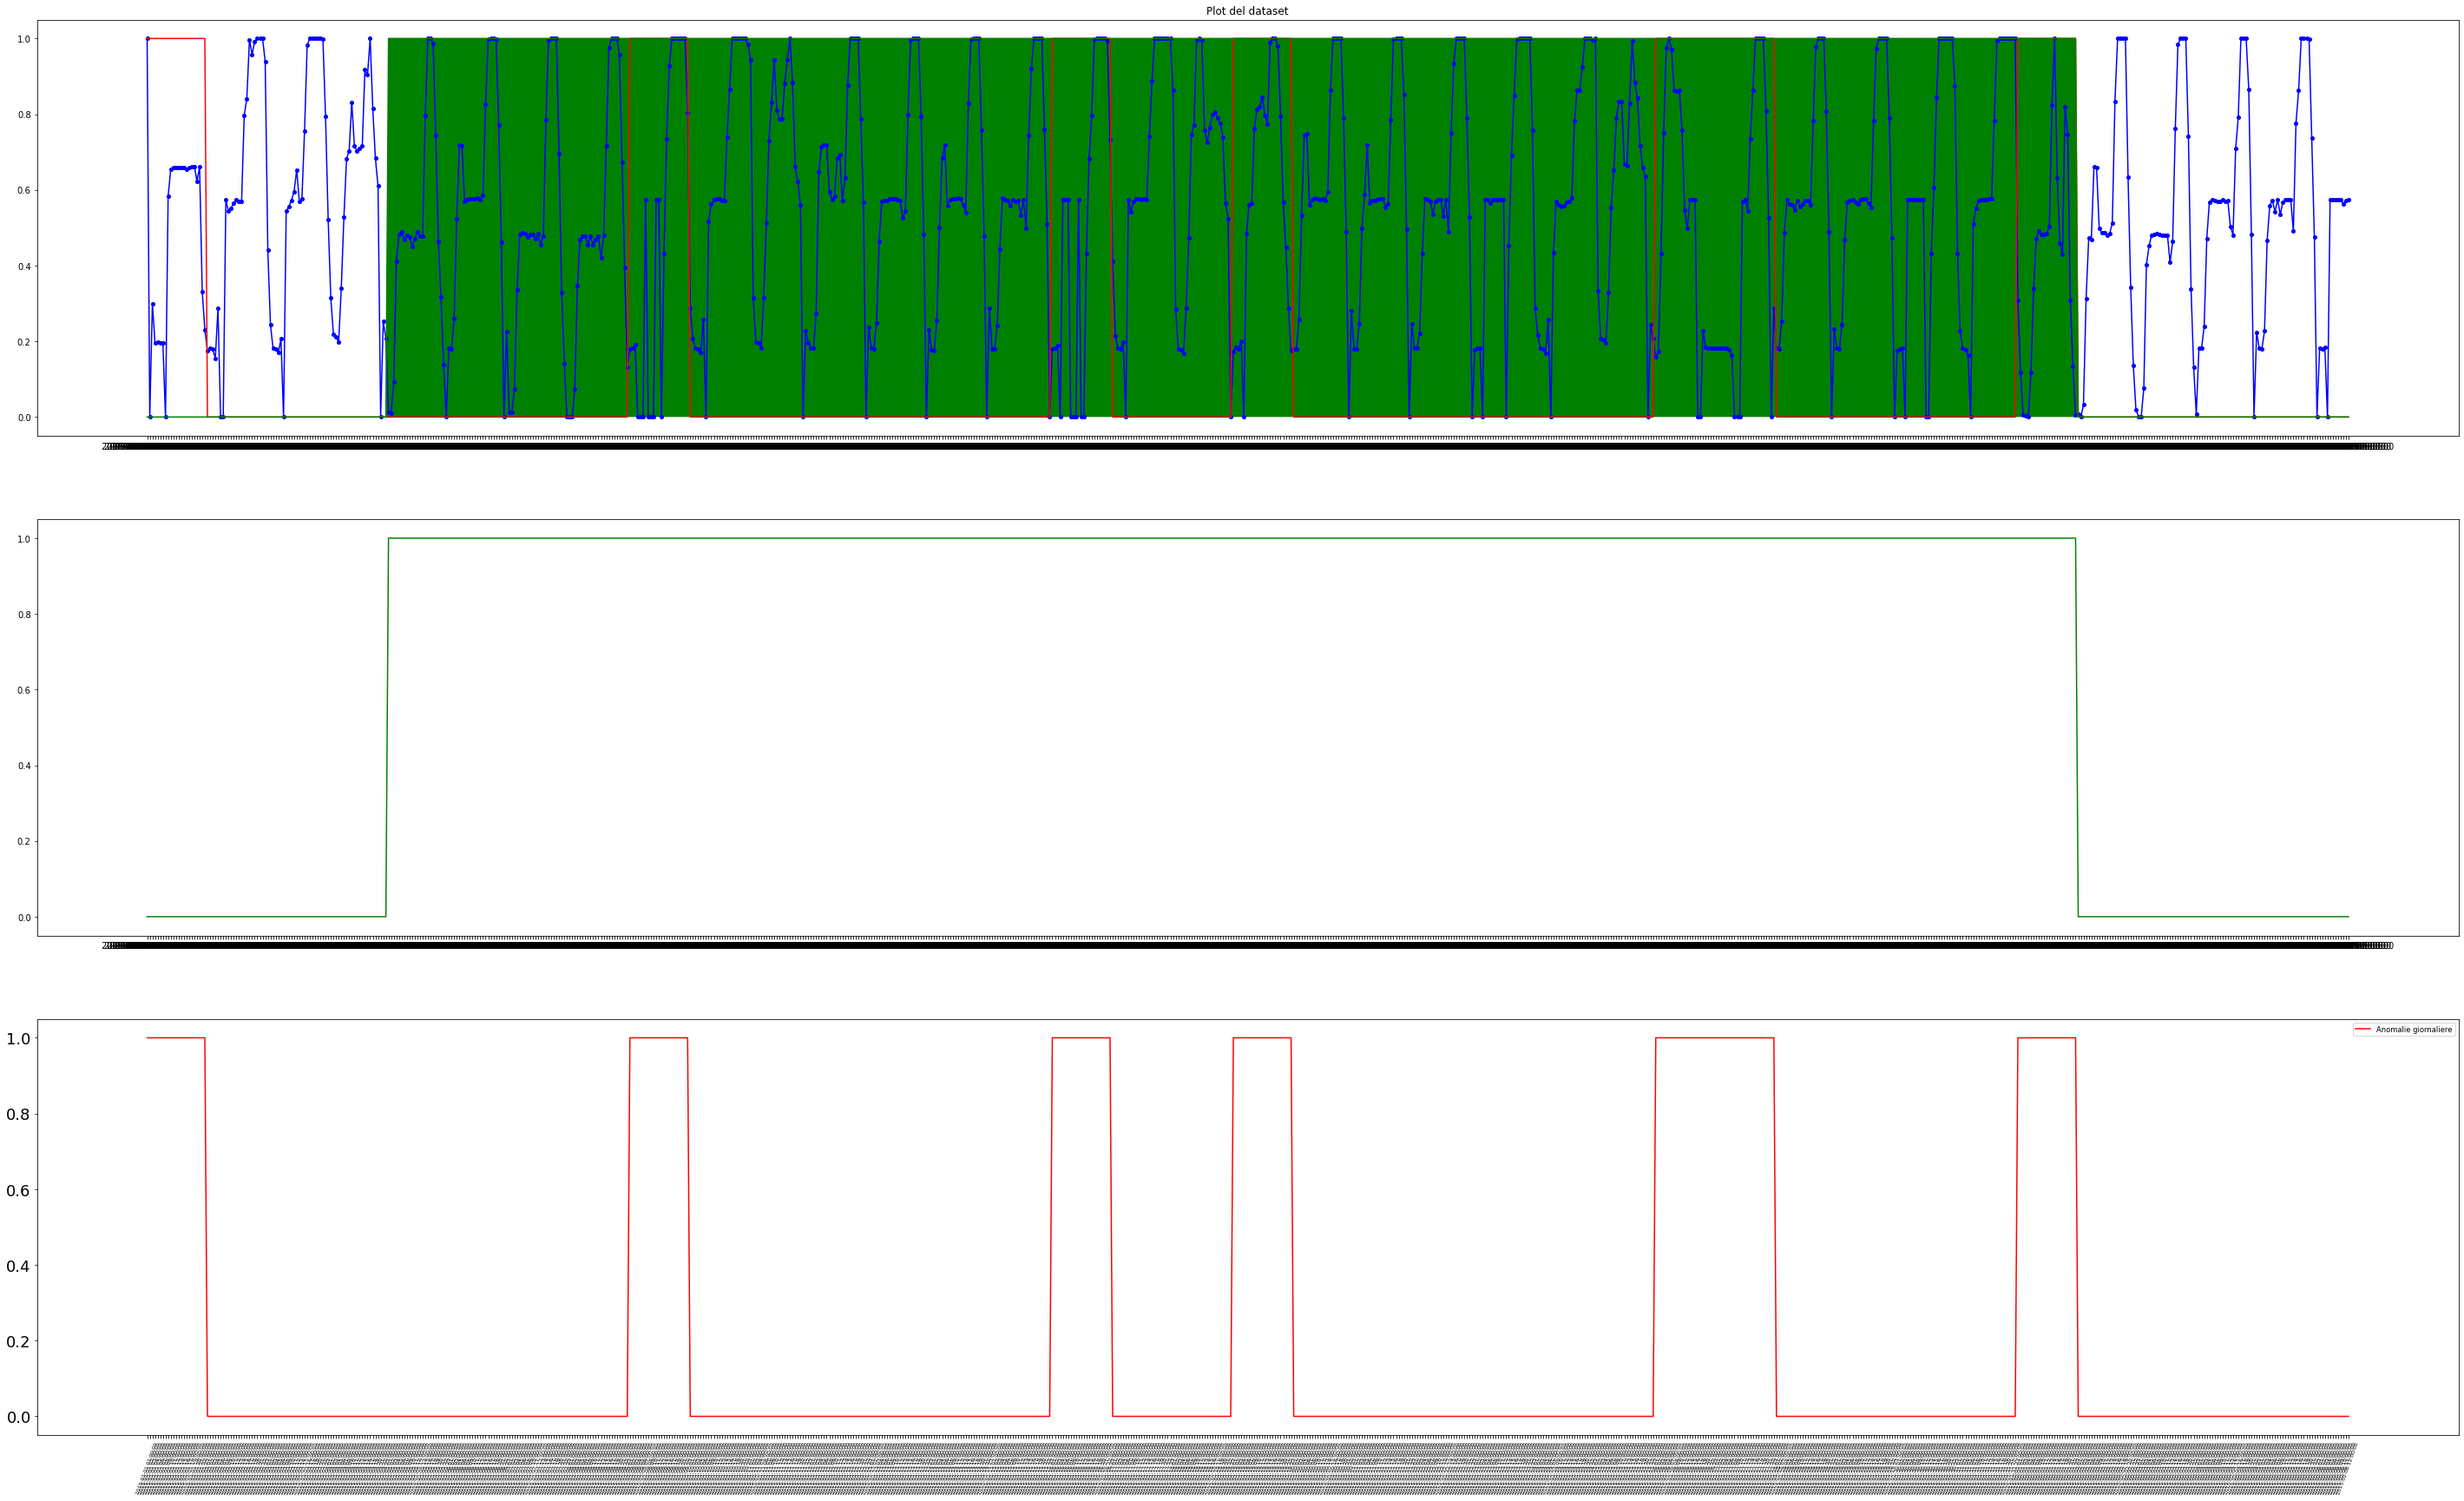

In [276]:
affluenze = pd.read_csv("vettorizzati_con_anomalous.csv",index_col="Data")

settimana_anomala_ridondante = []

for x in affluenze.itertuples() :
  day = datetime.datetime.strptime(x[0],"%Y-%m-%d %H:%M:%S")
  if day.isocalendar()[1] < 52 and new["Anomalous"][day.isocalendar()[1]] == 1 :
    settimana_anomala_ridondante.append(1)
  else :
    settimana_anomala_ridondante.append(0)

affluenze["Settimana anomala"] = settimana_anomala_ridondante
affluenze = affluenze.iloc[0:24*7*5] # cinque settimane

affluenze.to_csv("con_settimana_anomala.csv")

train = settati[["h1","h2","h3"]]

scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

plot_1 = pd.DataFrame(data=train,index=settati.index,columns=["h1","h2","h3"])
plot_1["Anomalous"] = settati["Anomalous"]

f1 = plt.figure(figsize=(50, 30))
plt.subplot(311)  

plt.title("Plot del dataset")

plt.plot(affluenze.index, affluenze["Affluenza"],color='b',marker="o",markersize=4, label='Serie temporale affluenza')

plt.plot(affluenze.index,affluenze["Anomalous"],color='r',label='Anomalie giornaliere')

plt.plot(affluenze.index,affluenze["Settimana anomala"],color='g',label='Settimane anomale')
plt.fill(affluenze.index, affluenze["Settimana anomala"], 'g')

plt.subplot(312)   

plt.plot(affluenze.index,affluenze["Settimana anomala"],color='g',label='Settimane anomale')

plt.subplot(313)
plt.plot(affluenze.index,affluenze["Anomalous"],color='r',label='Anomalie giornaliere')

plt.legend(loc='best', fontsize='small')
plt.xticks(fontsize=6)
plt.yticks(fontsize=18)
plt.xticks(rotation=70)

plt.show()